# Import Packages

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 500)

# Read Data

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/Citadel Datathon/Data/'

df_match = pd.read_csv(PATH+'match.csv')
df_team = pd.read_csv(PATH+'team.csv', encoding = 'ISO-8859-1')
df_team_attr = pd.read_csv(PATH+'team_attributes.csv')

# Get Bidding Info and Target Variable

## Remove NA in Bidding Columns



*   **League 15172** and **24558 **does not have any bidding info, so they are dropped
*   **PSA** does not have value for 2008/2009, 2009/2010, 2010/2011, 2011/2012
*   **SJA** does not have data for 2014/2015, 2015/2016
*   **GBA** and **BSA** does not have data for 2013/2014, 2015, 2016 and only half for 2013
*   PS, SJ, GB, BS are dropped
*   There are **41 matches** which do not have any bidding information, so they are not biddable and they are dropped.
*   There are still some missing values in bidding info, but that is fine, just be careful during backtesting



In [25]:
df_match.columns

Index(['country_id', 'league_id', 'season', 'stage', 'date', 'match_id',
       'home_team_id', 'away_team_id', 'home_team_goal', 'away_team_goal',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1',
       'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
       'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
       'away_player_10', 'away_player_11', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD',
       'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA',
       'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object')

In [26]:
# Choose the bidding columns with checking if the column name starts with uppercase letter
bidding_cols = [i for i in df_match.columns if i[0].isupper()]
df_bid_raw = df_match[['league_id','match_id','season','stage','date','home_team_goal','away_team_goal'] + bidding_cols]

In [27]:
# Convert the date to pandas datetime
df_bid_raw.date = pd.to_datetime(df_bid_raw.date)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
df_bid_raw['year'] = df_bid_raw.date.dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


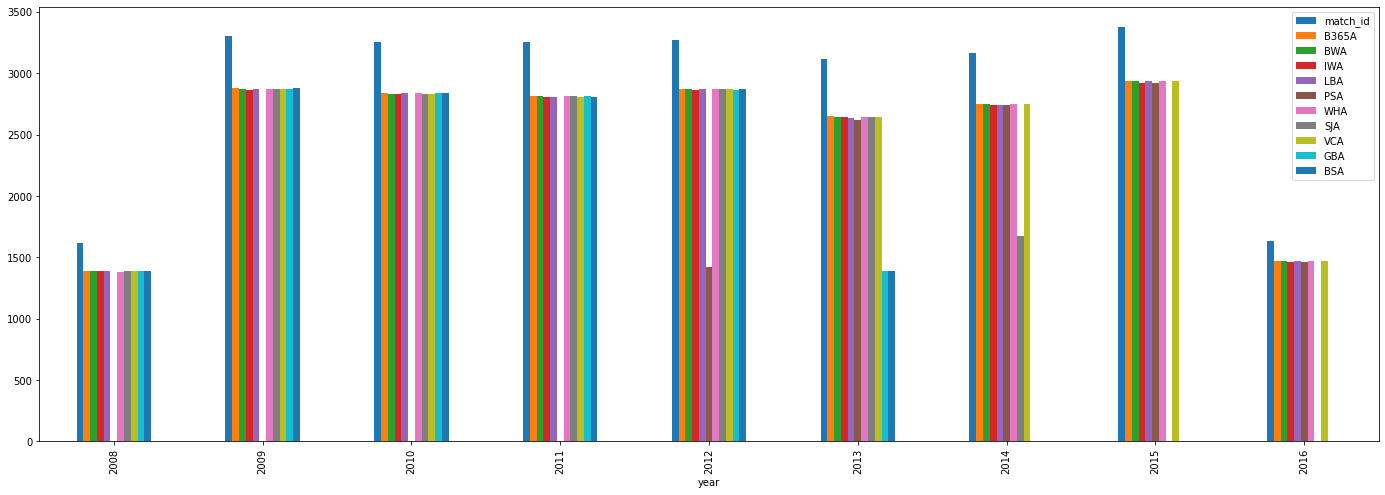

In [29]:
# Check how the missing values distributed by year
# PSA does not have value for 2008, 2009, 2010, 2011 and half data for 2012
# SJA does not have data for 2015 and 2016 and half data for 2014
# GBA and BSA does not have data for 2014, 2015, 2016 and only half for 2013
df_bid_raw.groupby(['year'])[['match_id']+[i for i in bidding_cols if 'A' in i]].count().plot.bar(figsize=(24,8))

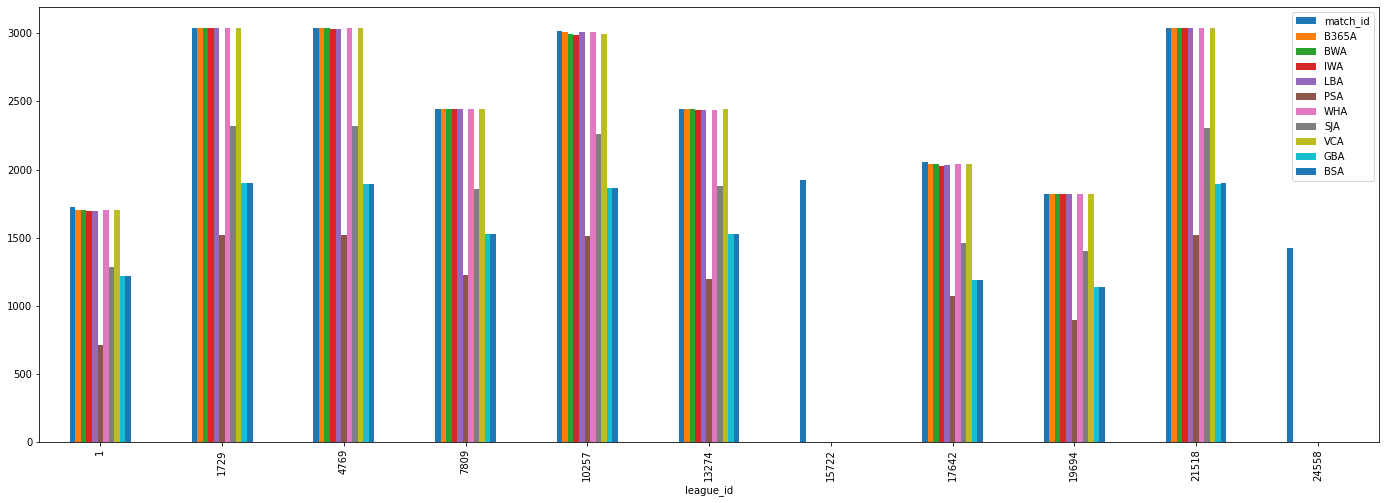

In [30]:
# Check how the missing values distributed by league
# League 15172 and 24558 does not have any bidding info!
df_bid_raw.groupby(['league_id'])[['match_id']+[i for i in bidding_cols if 'A' in i]].count().plot.bar(figsize=(24,8))

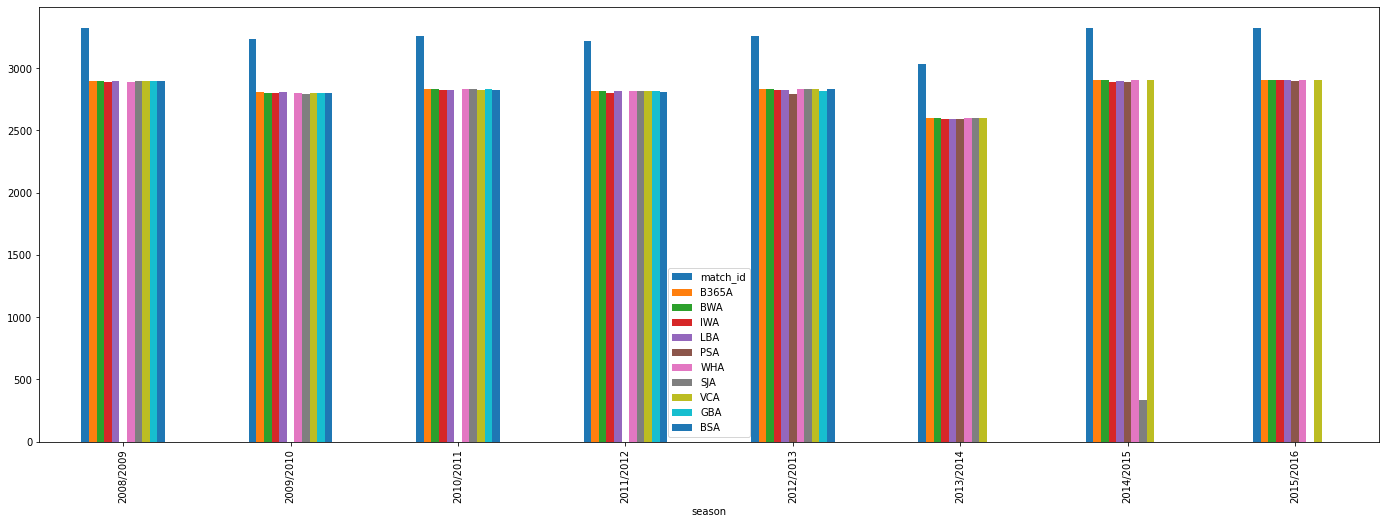

In [31]:
# Check how the missing values distributed by season
# PSA does not have value for 2008/2009, 2009/2010, 2010/2011, 2011/2012
# SJA does not have data for 2014/2015, 2015/2016
# GBA and BSA does not have data for 2013/2014, 2014/2015, 2015/2016
df_bid_raw.groupby(['season'])[['match_id']+[i for i in bidding_cols if 'A' in i]].count().plot.bar(figsize=(24,8))

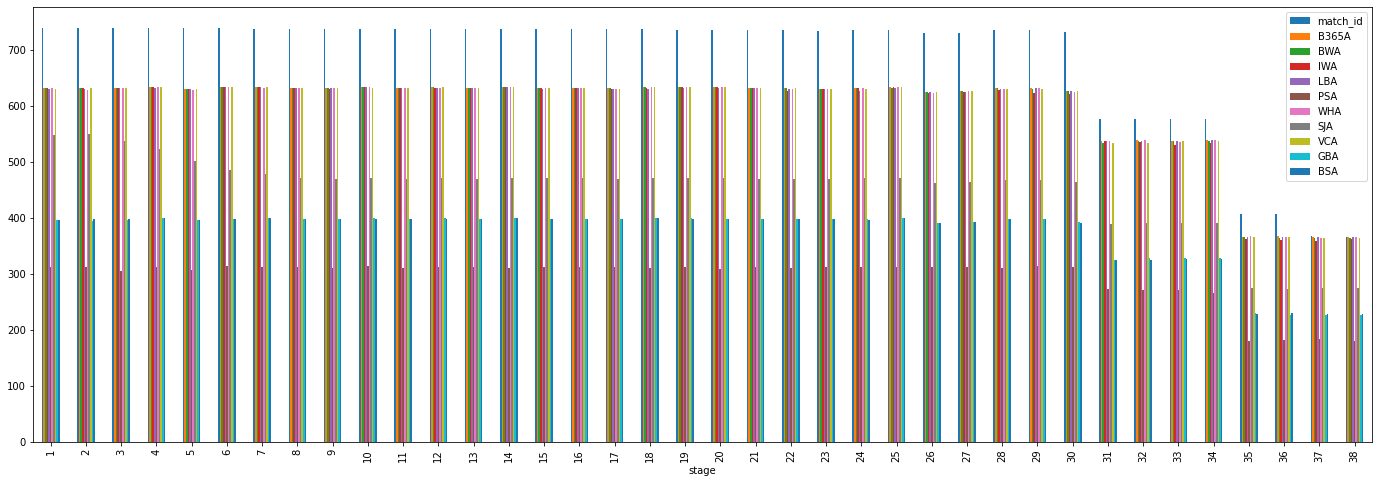

In [32]:
# Stage does not affect bidding information
df_bid_raw.groupby(['stage'])[['match_id']+[i for i in bidding_cols if 'A' in i]].count().plot.bar(figsize=(24,8))

In [33]:
# Drop league 15172 and 24558
df_bid = df_bid_raw[~df_bid_raw.league_id.isin(['15722','24558'])]

# Drop bidding company PSA, SJA, GBA, BSA
df_bid = df_bid[[i for i in df_bid.columns if i[:2] not in set(['PS','SJ','GB','BS'])]]

new_bidding_cols = [i for i in df_bid.columns if i[0].isupper()]

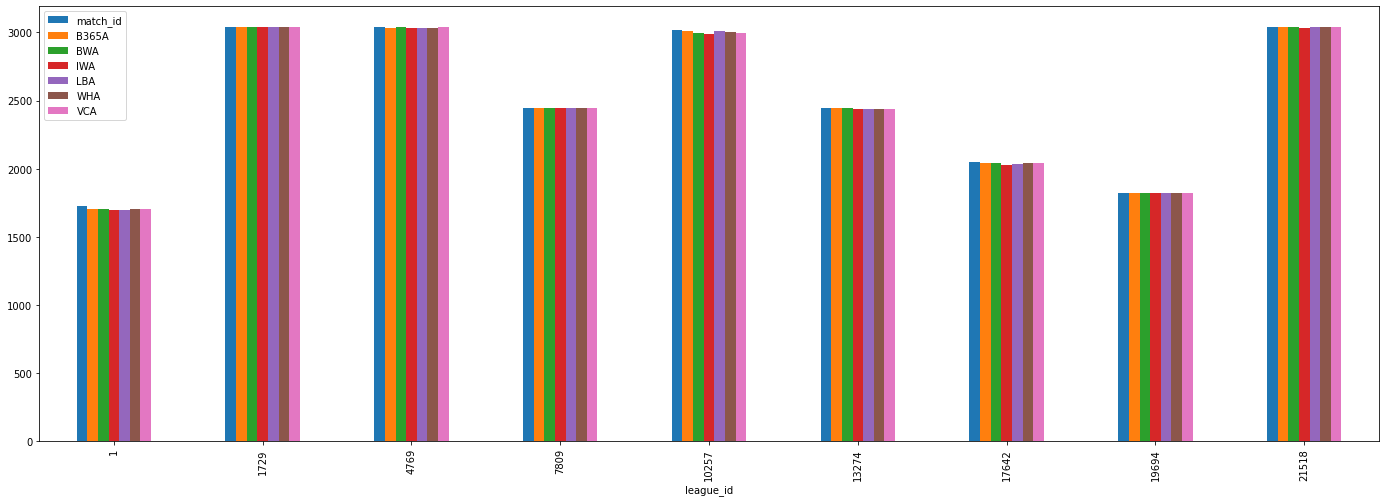

In [34]:
# Checking on the non-null values again against 'match_id'
# Now less null values are presented
df_bid.groupby(['league_id'])[['match_id']+[i for i in new_bidding_cols if 'A' in i]].count().plot.bar(figsize=(24,8))

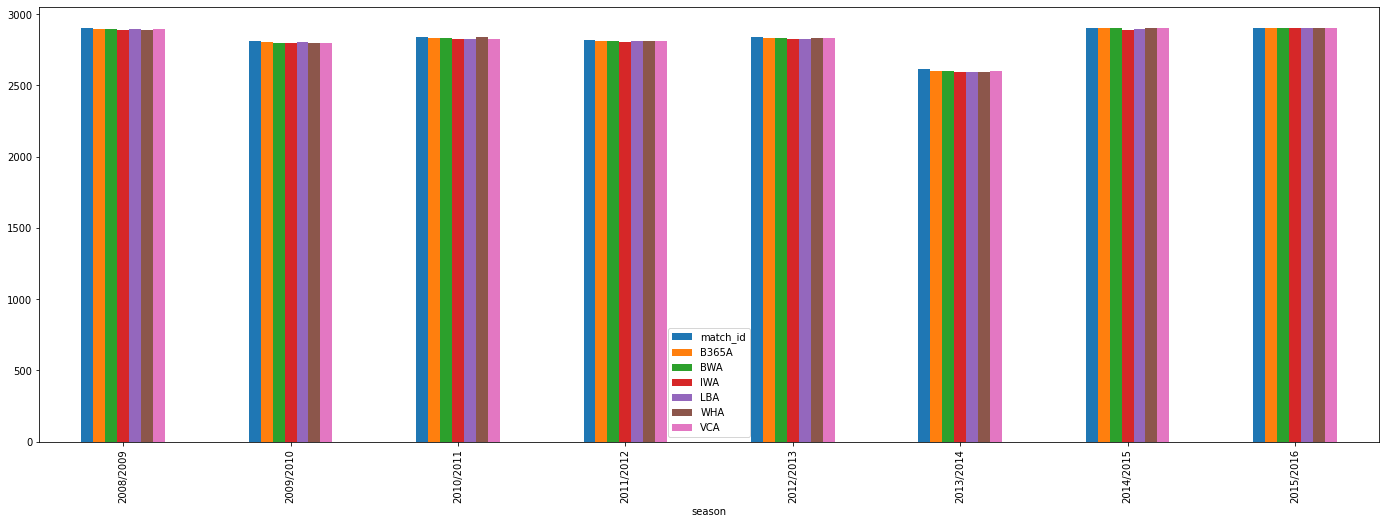

In [35]:
df_bid.groupby(['season'])[['match_id']+[i for i in new_bidding_cols if 'A' in i]].count().plot.bar(figsize=(24,8))

In [36]:
df_bid.shape

(22637, 26)

In [37]:
# There is still some matches that do not have any bidding information
# Drop these rows
df_bid = df_bid.dropna(axis=0, subset=new_bidding_cols, how='all')
print(df_bid.shape)

(22596, 26)


In [38]:
df_bid.drop_duplicates(subset=['match_id']).shape

(22596, 26)

In [42]:
pd.isnull(df_bid).sum()

league_id          0
match_id           0
season             0
stage              0
date               0
home_team_goal     0
away_team_goal     0
B365H              4
B365D              4
B365A              4
BWH               21
BWD               21
BWA               21
IWH               76
IWD               76
IWA               76
LBH               40
LBD               40
LBA               40
WHH               25
WHD               25
WHA               25
VCH               28
VCD               28
VCA               28
year               0
match_result       0
dtype: int64

## Get Match Result



*   Convert the goals into categorical variable **'match_result'**
*   The **'match_result'** would have three categorical values: **win, lose, draw**
*   According to the distribution, there is more win than lose and draw, so we might need to consider **home team effect** if model does not perform.


In [40]:
def get_result(row):
  home_goal = row['home_team_goal']
  away_goal = row['away_team_goal']

  if home_goal > away_goal:
    return "win"
  elif home_goal < away_goal:
    return 'lose'
  else:
    return 'draw'
df_bid['match_result'] = df_bid.apply(get_result, axis=1)

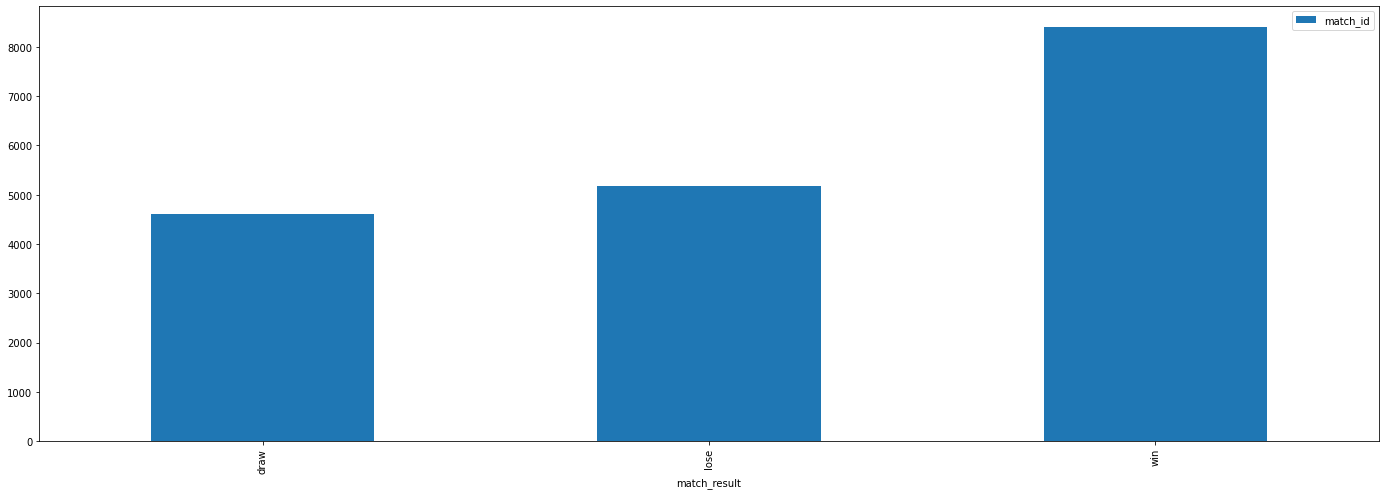

In [41]:
# Checking the distribution of match result in 'training data'
# The draw does matter
df_bid[df_bid.year<=2014].groupby(['match_result'])[['match_id']].count().plot.bar(figsize=(24,8))

## Add Continuous target variable match_result_rel



1.   Derive a continuous target variable '**match_result_rel**' from goals
2.   match_result_rel = 0 if draw else (**home_goal - away_goal) / max(home_goal, away_goal)**
3.   The 'match_result_rel' would have a range of **[-1,1]**
4.   The rational is that if we just looking at win/lose, we are not able to identify the relative amount.



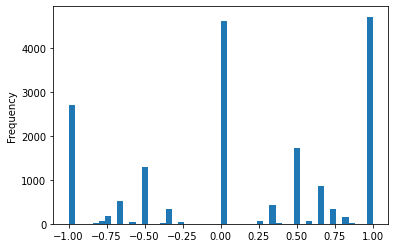

In [43]:
# Match_result_rel = (home_goal - away_goal) / max(home_goal, away_goal)
# Consider increase the home team attribute due to home team effect?
# 
def get_match_result_rel(row):
  home_goal = row['home_team_goal']
  away_goal = row['away_team_goal']
  if home_goal == away_goal:
    return 0
  else:
    return (home_goal - away_goal) / max(home_goal, away_goal)
df_bid['match_result_rel'] = df_bid.apply(get_match_result_rel, axis=1)
df_bid[df_bid.year<=2014].match_result_rel.plot.hist(bins=50)

In [44]:
#print(df_bid.columns)

df_bid[['league_id','match_id','season','stage','date','home_team_goal','away_team_goal','match_result', 'match_result_rel']].to_csv(PATH + 'Ziao/target.csv',index=False)
df_bid[['league_id','match_id','season','stage','date','home_team_goal','away_team_goal','match_result', 'match_result_rel'] + [i for i in df_bid.columns if i[0].isupper()]].to_csv(PATH + 'Ziao/bidding.csv',index=False)

# Clean Team Data



1.   Drop **feature with 'Class'** as they are highly correlated with their continuous version, but they have less information
2.   Drop feature **'buildUpPlayDribbling'** because it does not have value from **2010 to 2013**



In [45]:
pd.isnull(df_team_attr).sum()

team_id                             0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [46]:
for col in df_team_attr:
    if 'Class' in col:
      print(df_team_attr[col].unique())

['Balanced' 'Fast' 'Slow']
['Little' 'Normal' 'Lots']
['Mixed' 'Long' 'Short']
['Organised' 'Free Form']
['Normal' 'Risky' 'Safe']
['Normal' 'Lots' 'Little']
['Normal' 'Lots' 'Little']
['Organised' 'Free Form']
['Medium' 'Deep' 'High']
['Press' 'Double' 'Contain']
['Normal' 'Wide' 'Narrow']
['Cover' 'Offside Trap']


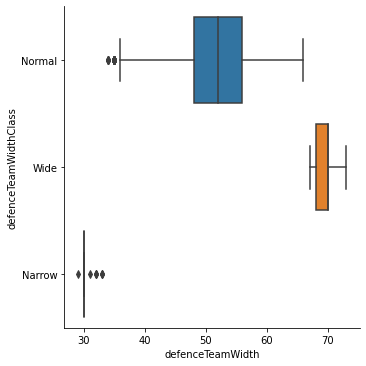

In [47]:
# Check correlations between class and continuous variable
# They are perfectly correlated. Thus we can drop the class feature except for buildUpPlayDribblingClass
import seaborn as sns
sns.catplot(x="defenceTeamWidth", y="defenceTeamWidthClass", kind="box", data=df_team_attr)

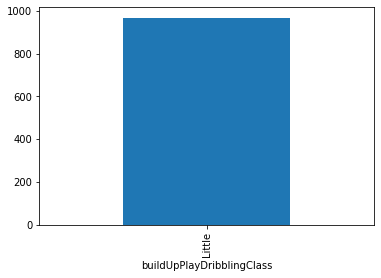

In [48]:
# Special checking for buildUpPlayDribbling
# All missing values for buildUpPlayDribbling has 'Little' in buildUpPlayDribblingClass
df_team_attr[pd.isnull(df_team_attr.buildUpPlayDribbling)].groupby(['buildUpPlayDribblingClass'])['team_id'].count().plot.bar()

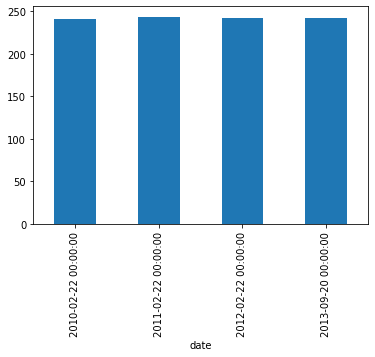

In [49]:
# Check missing value for buildUpPlayDribbling vs date
df_team_attr.date = pd.to_datetime(df_team_attr.date)
df_team_attr[pd.isnull(df_team_attr.buildUpPlayDribbling)].groupby(['date'])['team_id'].count().plot.bar()

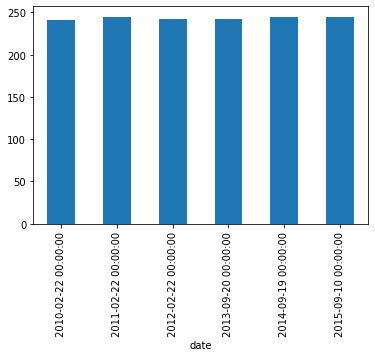

In [50]:
# Compared the two bar charts we know that buildUpPlayDribbling does not have any value from 2010 to 2013
# Consider dropping it
# Addtional insights: team only has data from 2010 to 2015
df_team_attr.groupby(['date'])['team_id'].count().plot.bar()

In [51]:
df_team_attr.shape

(1458, 23)

In [52]:
df_team_attr[df_team_attr.team_id == 9996]

,team_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
859,9996,2015-09-10,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover
860,9996,2015-09-10,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover


In [53]:
df_team_attr = df_team_attr.drop_duplicates(subset=['team_id', 'date'])

In [54]:
df_team_attr[(i for i in df_team_attr.columns if 'Class' not in i and 'buildUpPlayDribbling' not in i)].to_csv(PATH + 'Ziao/team_attributes.csv', index=False)